# Na channels: current-voltage relationship (I-V)

#### **Basic instructions:**
#### 1. **To run code windows/blocks:** 

    - you can either hit the play button to the left of the code window 

    - or you can use they keyboard shortcut: select the block and press 'shift-enter'.

#### 2. The first time you run this code notebook, you will get a popup asking to choose which version of Python to use (the python "kernel"). **Choose the python kernel called "CSHL_IonChannels"**

    - If you did it correctly, you should see "CSHL_IonChannels (Python 3.11.13)" in the top right of the screen.

#### 3. Make sure you data (.abf) files are in the "data" folder here on the left. You can just copy/paste the files from where they are saved on your computer.

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
update_plot_defaults()
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Choose the data file you want to analyze

#### Put the .abf files with your Na channel recordings in the "data/Na_channels" folder

In [16]:
data_folder = "data/1-Na_channels"

from glob import glob
data_files = glob(data_folder+"/*.abf")
print(data_folder)
data_files

data/1-Na_channels


['data/1-Na_channels/nav18-iv.abf',
 'data/1-Na_channels/nav18-ssinact.abf',
 'data/1-Na_channels/nav_inactivation_recovery -120mv_3.abf']

You should see a list of files above (assuming you put the data in the correct folder)

Choose which file you want to analyze and copy/paste the file name here:

In [17]:
data_file = 'data/1-Na_channels/nav18-iv.abf'

Now we can load the file and plot the raw data:

(If you want to save the images, you can do it by clicking on the save icon in the top-right of the image when you hover over it)

Trace('nav18-iv.abf')
Number of sweeps: 26
Points per sweep: 5,160
Duration per sweep: 0.052 s
Sampling rate: 100000 Hz
Sampling interval: 0.010 ms
Available channels: Current, Voltage


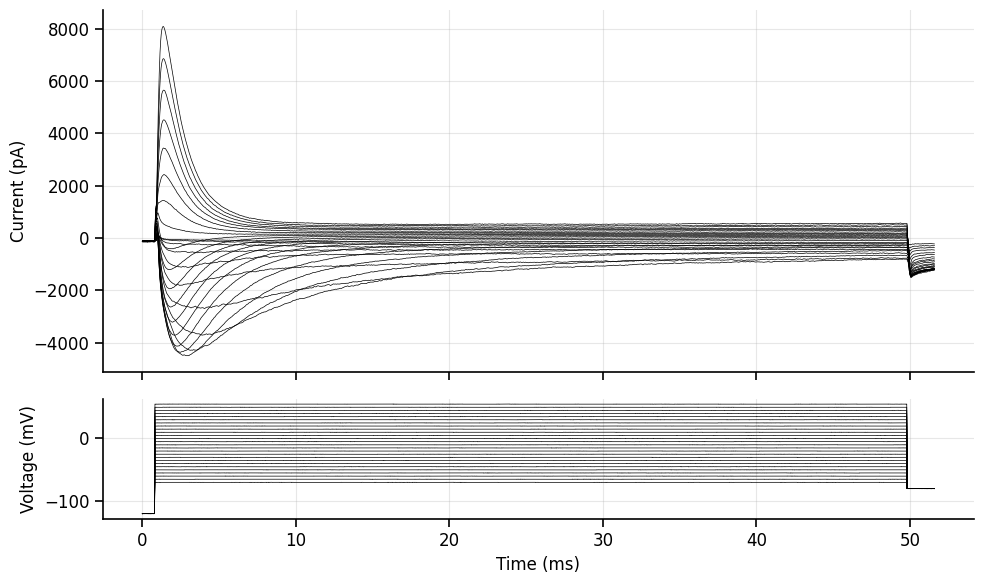

Voltage step time: [0.79] to [49.8] ms


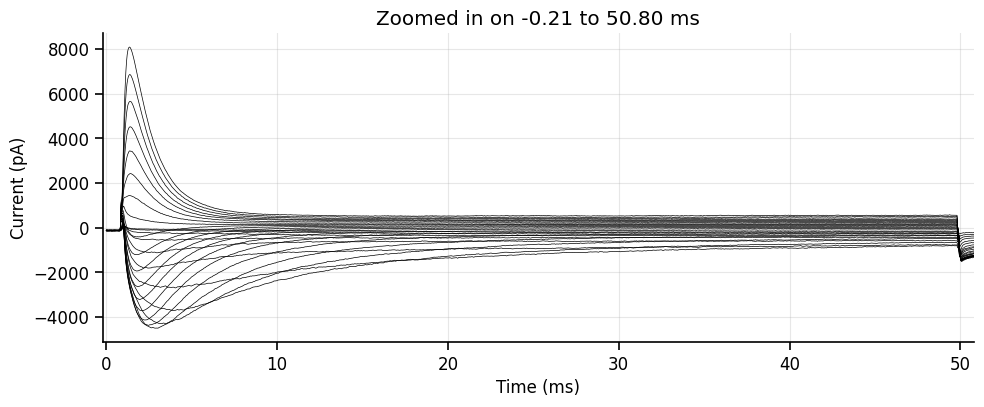

In [18]:
traces = Trace.from_axon_file(filename=data_file, 
                              load_voltage=True, 
                              load_ttl=False,
                              units=['pA', 'mV'])
print(traces)

time_units = 'ms' # specify seconds (s), or milliseconds (ms)


# ----------------------------------------------------------------------------------------------------------------
# The %matplotlib widget lines makes plots interactive (but sometimes is a bit buggy, doesn't always work)

# %matplotlib widget
%matplotlib inline
ax = traces.plot(plot_voltage=True, sweep='all', time_units=time_units)
plt.show()

v_step_start = traces.get_step_events(threshold=traces.voltage_data[0,0]+5, channel='voltage', edge='rising', polarity='positive', time_units=time_units, sweep=0)
v_step_end = traces.get_step_events(threshold=traces.voltage_data[0,-1]+5, channel='voltage', edge='falling', polarity='positive', time_units=time_units, sweep=0)
print(f"Voltage step time: {v_step_start} to {v_step_end} ms")
x_axis_range = (v_step_start[0]-1, v_step_end[0]+1)
ax = traces.plot(plot_voltage=False, sweep='all', time_units=time_units)
ax.set_xlim(x_axis_range)
ax.set_title(f'Zoomed in on {x_axis_range[0]:.2f} to {x_axis_range[1]:.2f} {time_units}')
plt.show()

## 2. Signal processing

### Baseline the trace and apply highpass / lowpass / bandpass filtering

We want to measure the current amplitude relative to the baseline before the stimulus starts.  

Depending on you recording, you may also have 50/60 Hz line noise, high-frequency noise, or slow drift in your recording that we can correct for.

You can run this next cell as many times as you want to fine-tune the filtering parameters:

BASELINE SUBTRACTED:
Baseline currents (pA): [-111.2926 -133.1339 -113.1314 ... -125.1298 -132.7631 -135.104 ]


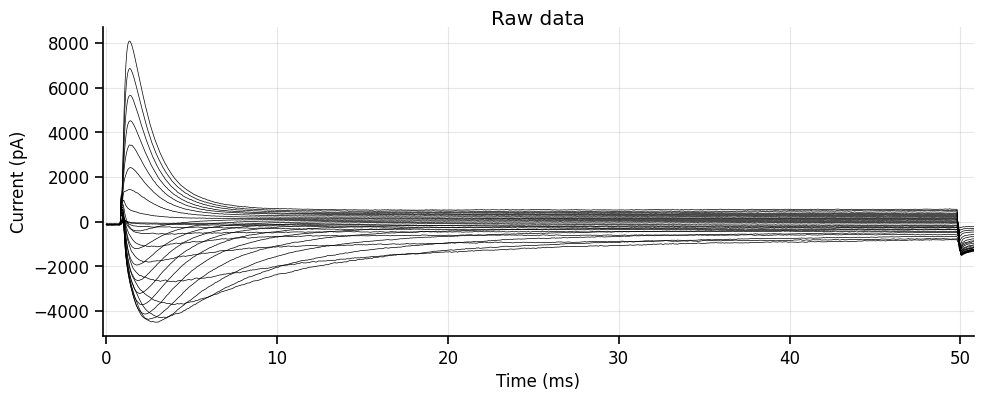

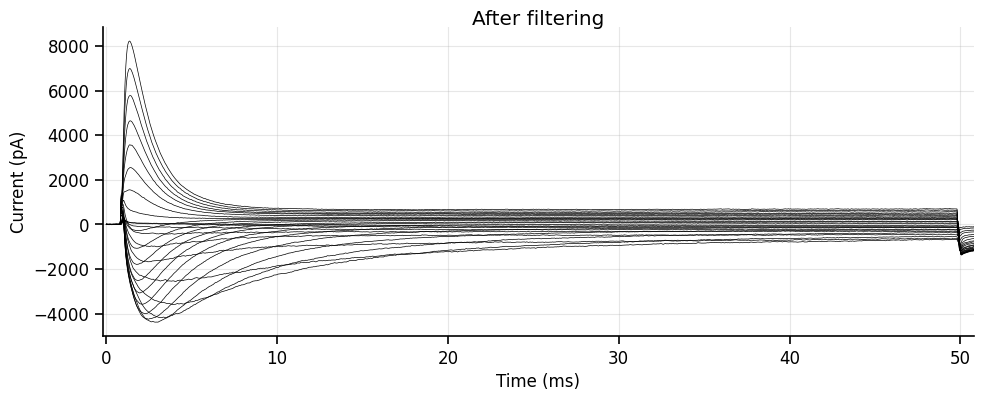

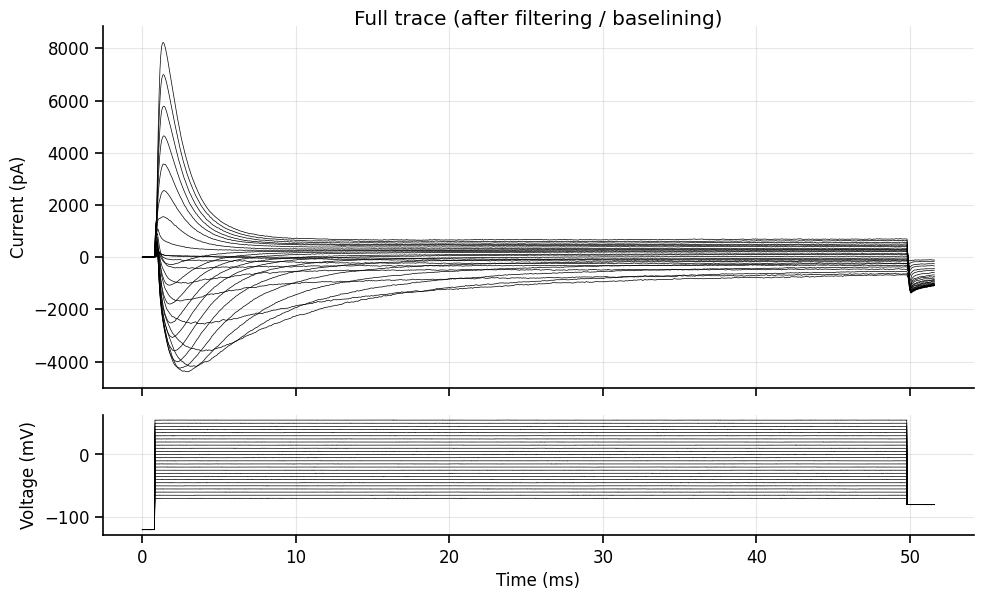

In [19]:
subtract_baseline = True    # Subtract baseline to measure the current relative to the baseline (just before the voltage step)

linear_detrending = False   # Detrend the data to remove linear or constant trends (e.g slow drift)
lowpass_filter    = False   # Lowpass filter (removes high-frequency noise)
bandpass_filter   = False   # Bandpass filter (removes 50/60 Hz mainline noise)


# ----------------------------------------------------------------------------------------------------------------
filtered_traces = traces.copy()
if linear_detrending:
    # Detrend the data to remove linear or constant trends (e.g slow drift)
    filtered_traces = filtered_traces.detrend(detrend_type='linear', num_segments=1)

if lowpass_filter:
    # Lowpass filter (removes high-frequency noise)
    filtered_traces = filtered_traces.lowpass_filter(cutoff_freq = 4000) # Choose a value in units of Hz
    
if bandpass_filter:
    # Bandpass filter (removes 50/60 Hz mainline noise)
    filtered_traces = filtered_traces.filter_line_noise(
        line_freq = 60, # Frequency (Hz) of noise to remove: 50 Hz (in Europe) or 60 Hz (in the US).
        width = 1, # Width (Hz) controls the width of frequency bands around the line frequency the filter cuts out.
        method = 'notch') # Options: 'notch' (IIR notch filter), 'bandstop' (Butterworth), or 'fft' (spectral).

if subtract_baseline:
    start_baseline = max(0, v_step_start[0]-5)  # Start time for baseline subtraction
    end_baseline = v_step_start[0]  # End time for baseline subtraction
    filtered_traces.subtract_baseline(start_time = start_baseline, end_time = end_baseline , time_units = time_units, channel = 'current')

# Plot the traces before and after filtering
if any([linear_detrending, lowpass_filter, bandpass_filter, subtract_baseline]):
    # %matplotlib widget
    %matplotlib inline
    ax = traces.plot(plot_voltage=False, time_units=time_units, sweep='all')
    ax.set_xlim(x_axis_range)
    ax.set_title('Raw data', y=0.98)
    plt.show()
    ax = filtered_traces.plot(plot_voltage=False, time_units=time_units, sweep='all')
    ax.set_xlim(x_axis_range)
    ax.set_title('After filtering', y=0.98)
    plt.show()
    ax = filtered_traces.plot(plot_voltage=True, time_units=time_units, sweep='all')
    ax[0].set_title('Full trace (after filtering / baselining)', y=0.98)
    plt.show()


Once you are happy with the filter setting, run the next cell to implement them:

In [20]:
if any([linear_detrending, lowpass_filter, bandpass_filter, subtract_baseline]):
    print("Applied filtering and/or baseline subtraction to the traces.")
    traces = filtered_traces

Applied filtering and/or baseline subtraction to the traces.


## 3. Measure the peak currents

First we will define the time window where we want to measure the peak (both positive and negative) currents

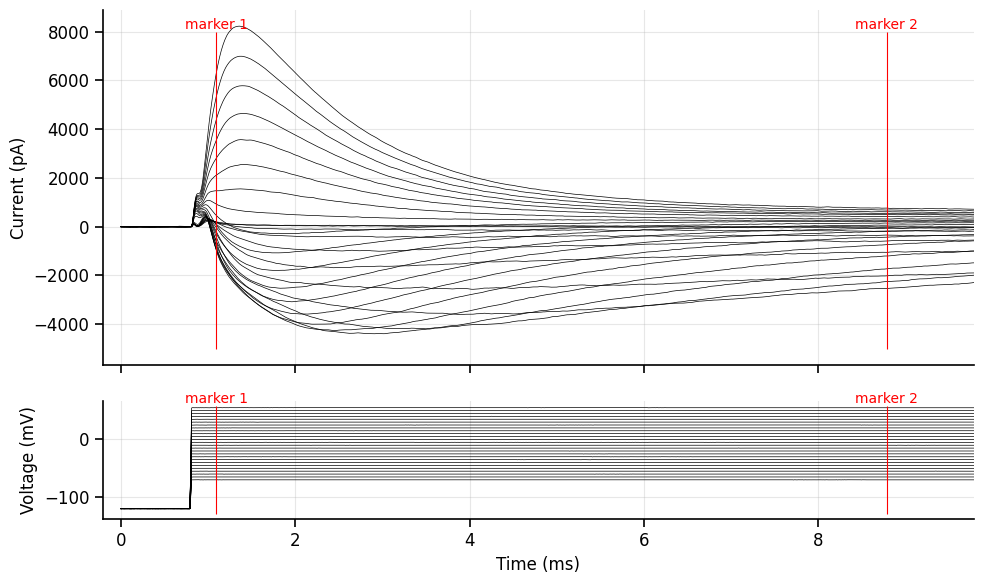

In [21]:
# The markers here will define the window where we will measure peak current values. If they don't look right you can adjust them to make sure you include all the current peaks without the stim artifact.
marker_1 = v_step_start[0] + 0.3
marker_2 = v_step_start[0] + 8

# ----------------------------------------------------------------------------------------------------------------------
# change to %matplotlib inline if the interactive plot is not showing
%matplotlib inline
# %matplotlib widget   
ax1,ax2 = traces.plot(plot_voltage=True, time_units=time_units, marker_1=marker_1, marker_2=marker_2, sweep='all')
ax1.set_xlim(x_axis_range[0], x_axis_range[0]+10)  # Extend the x-axis a bit to the right
ax2.set_xlim(x_axis_range[0], x_axis_range[0]+10)  # Extend the x-axis a bit to the right
plt.show()

Now we can use the timepoints from the markers we defined above to measure the peak current for each voltage step.

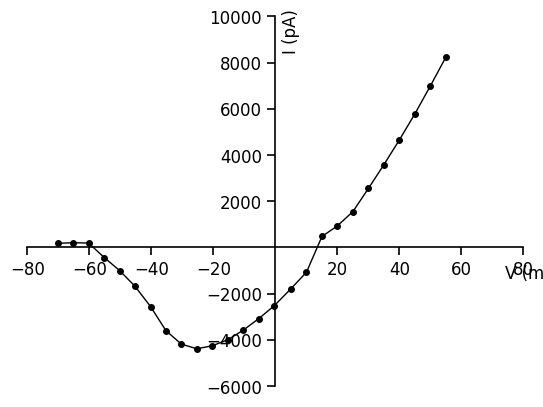

In [22]:
measurement_type = 'peak' # Options: 'mean', 'max', 'min', 'peak'

current_steps, voltage_steps = traces.get_measurements(start_time=marker_1, end_time=marker_2, 
                                                       measurement_type=measurement_type, time_units=time_units)

if np.all(voltage_steps == voltage_steps[0]):
    print("WARNING: All voltage steps are the same")
if np.all(current_steps == current_steps[0]):
    print("WARNING: All current steps are the same")
%matplotlib inline
ax = plot_IV(voltage_steps, current_steps)
plt.show()

## 4. Calculate activation curve

### 4.1. Estimate the reversal potential

To calculate the activation curve, we need to know the reversal potential (E) so that we can calculate the conductance at each voltage based on the driving force:

$G = \frac{I}{V - E}$

Here we will estimate E by fitting a line to the I-V points. As a bonus, the slope of the line (on the right, when the channel is fully open) will also give us an estimate of the maximum conductance.

G = slope = 156.988 nS
Resistance = 1/slope = 6.370 MOhm
Reversal potential: 14.506 mV


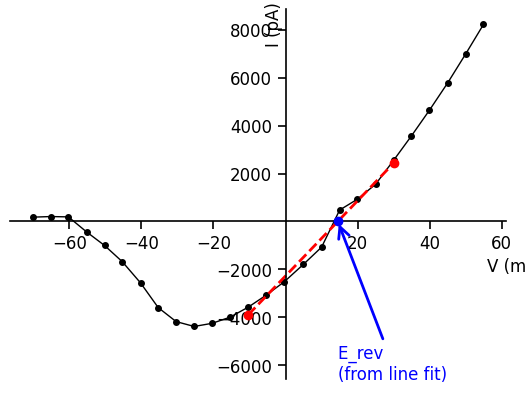

In [23]:
# Choose which range of point you want to fit a line to
# Here it is important to select a range of points in the "linear" (right) part of the IV curve, where the Na channels are open.

voltage_start = -10
voltage_end = +30

slope, intercept, E_rev = fit_IV_curve(voltage_steps, current_steps, voltage_start, voltage_end)

Before running the next few code windows, make sure that the line fit is good and gives an accurate measure of the reversal potential (E_rev). 

Otherwise your channel activation curve will be bad.

### 4.2. Calculate G for each point

<img src="images/Na_IV_activation_analysis.png" width="800">


Here we are deriving channel activation by calculating the conductance of the channel at different voltages

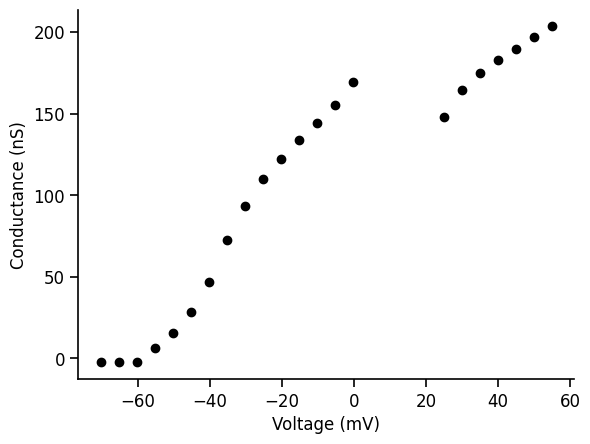

In [24]:
# Calculate the conductance at each point
G = current_steps / (voltage_steps - E_rev)

# We are estimating the G from single points, so errors will be larger close to the 
# reversal potential (where our calculation is very sensitive to small variations in V-E_rev).

# Remove the points within 5mv of the reversal potential
# (since the conductance is not well defined at the reversal potential)
delta_V = voltage_steps - E_rev
mask = np.abs(delta_V) > 10
voltage_steps = voltage_steps[mask]
current_steps = current_steps[mask]
G = G[mask]

# Plot the conductance
%matplotlib inline
fig = plt.figure()
plt.plot(voltage_steps, G, 'o', color='black')
plt.xlabel('Voltage (mV)')
plt.ylabel('Conductance (nS)')
plt.show()

Now we can normalize against the maximum conductance to fit a Boltzmann (sigmoid) function to the data.

Note that by definition the Boltzmann function can only go between 0 and 1.

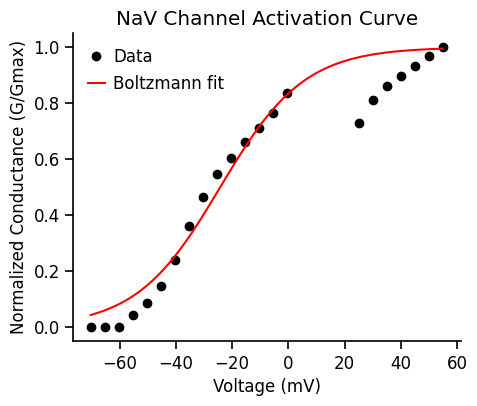

In [25]:
# Remove the baseline conductance (which should already be close to zero)
G = G - np.min(G)  

# Now we normalize these conductances by the maximum value, i.e. the fully open channel conductance
G_max = np.max(G) 

# # Sometime the Gmax measurement is a bit noisy, so can instead normalize against the average of the last 5 points
# G_max = np.mean(G[-5:]) 

# # Alternatively, we can use the line we fit above. 
# # If we fit the line correctly (around the E_rev), the slope of that line is the maximum conductance
# G_max = slope

# Now we normalize the conductances by the maximum value
G_norm = G / G_max

# --------------------------------------------------------------------------------------------------------------------
# Finally we can fit the Boltzmann function (sigmoidal curve) to the data 
def boltzmann(V, V_half, k):
    return 1 / (1 + np.exp((V_half - V) / k))

from scipy.optimize import curve_fit
k_guess = 5 # Initial guess for the slope parameter
popt, _ = curve_fit(boltzmann, voltage_steps, G_norm, p0=[np.median(voltage_steps), k_guess])
V_half_fit, k_fit = popt
V_fit = np.linspace(np.min(voltage_steps), np.max(voltage_steps), 500)
G_fit = boltzmann(V_fit, V_half_fit, k_fit)

# Plot normalized data points & fitted curve
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(voltage_steps, G_norm, 'o', label='Data', color='black')
ax.plot(V_fit, G_fit, '-', label='Boltzmann fit', color='red')
ax.set_xlabel('Voltage (mV)')
ax.set_ylabel('Normalized Conductance (G/Gmax)')
ax.set_title('NaV Channel Activation Curve')
ax.legend(handlelength=1, loc='upper left', handletextpad=0.5)
plt.show()